In [29]:
#I am trying to predict the future airplane prices
#To start with I am encoding the categorical data with label encoding
import pandas as pd
import numpy as np
import re 
from datetime import datetime, timedelta
# Import label encoder 
from sklearn import preprocessing,tree

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

#reading the dataset
df=pd.read_csv("Airlinedata.csv")
#print(df.dtypes)
#df.reset_index(inplace=False)

# label_encoder object knows how to understand word labels. 
label_encoder = preprocessing.LabelEncoder()

# List of columns you want to label encode
columns_to_encode = ['Airline', 'Source', 'Destination','Route','Additional_Info','Total_Stops']
# Encode each column
for column in columns_to_encode:
    df[column + '_en'] = label_encoder.fit_transform(df[column])

#temp = pd.DataFrame({'Duration': list(df['Duration'])})
#print(temp)
#print(df['Duration'])

#df['Duration_en'] = df['Duration'].apply(lambda x: convert_duration_to_datetime(x))
df[['Date_of_Journey']] = df[['Date_of_Journey']].apply(pd.to_datetime,format="%d/%m/%Y")
df['Duration_en'] = df['Duration'].apply(lambda x: duration_to_minutes(x))

#df['Duration_en'] = pd.to_datetime(df['Duration_en'], format='%H:%M %d %b')

#Processing Departure and Arrival data. Converting into datatime
####I am creating function to process the date of journet, depature and arrival time. Concatenating the date from date of journey
df['Dep_Time_Full'] = df.apply(lambda x: convert_dep_arr_to_datetime(x['Dep_Time'],x['Date_of_Journey']),axis=1)
df['Arr_Time_Full'] = df.apply(lambda x: convert_dep_arr_to_datetime(x['Arrival_Time'],x['Date_of_Journey']),axis=1)


#Converting Date of Journey field from datetime object to Timestamp 

df['Date_of_Journey_Timestamp'] = df['Date_of_Journey'].astype('int64') // 1e9
df['Date_of_Journey_Dayname'] = df['Date_of_Journey'].dt.day_name()
df['Date_of_Journey_Dayname' + '_en'] = label_encoder.fit_transform(df['Date_of_Journey_Dayname'])
df['Weekday_vs_Weekend'] = df['Date_of_Journey'].dt.dayofweek.apply(lambda x: 1 if x < 5 else 0)



#print(df['Date_of_Journey_Timestamp'])

df['Departure_Hour'] = pd.to_datetime(df['Dep_Time']).dt.hour
df['Departure_Minute'] = pd.to_datetime(df['Dep_Time']).dt.minute

df['Arrival_Hour'] = pd.to_datetime(df['Arrival_Time']).dt.hour
df['Arrival_Minute'] = pd.to_datetime(df['Arrival_Time']).dt.minute
df['Part_of_Day'] = pd.to_datetime(df['Dep_Time'], format='%H:%M').dt.hour.apply(part_of_day)
df['Part_of_Day_en'] = label_encoder.fit_transform(df['Part_of_Day'])

#print(list(df['Duration']))
print(df.head(1))
df.dtypes

  Airline Date_of_Journey    Source Destination      Route Dep_Time  \
0  IndiGo      2019-03-24  Banglore   New Delhi  BLR → DEL    22:20   

   Arrival_Time Duration Total_Stops Additional_Info  ...  \
0  01:10 22 Mar   2h 50m    non-stop           Null   ...   

   Date_of_Journey_Timestamp  Date_of_Journey_Dayname  \
0               1.553386e+09                   Sunday   

   Date_of_Journey_Dayname_en  Weekday_vs_Weekend  Departure_Hour  \
0                           3                   0              22   

   Departure_Minute  Arrival_Hour  Arrival_Minute Part_of_Day Part_of_Day_en  
0                20             1              10       Night              3  

[1 rows x 30 columns]


Airline                               object
Date_of_Journey               datetime64[ns]
Source                                object
Destination                           object
Route                                 object
Dep_Time                              object
Arrival_Time                          object
Duration                              object
Total_Stops                           object
Additional_Info                       object
Price                                  int64
Airline_en                             int32
Source_en                              int32
Destination_en                         int32
Route_en                               int32
Additional_Info_en                     int32
Total_Stops_en                         int32
Duration_en                            int64
Dep_Time_Full                 datetime64[ns]
Arr_Time_Full                 datetime64[ns]
Date_of_Journey_Timestamp            float64
Date_of_Journey_Dayname               object
Date_of_Jo

In [30]:
#Preprocessing data for one-Hot Encoding 
df['Airline'].unique()
df['Airline'].nunique()
df_encoded = pd.get_dummies(df, columns=['Airline','Source','Destination','Total_Stops' ])
print(df_encoded.info())
df_encoded.to_csv('AirlinecuratedData.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 54 columns):
 #   Column                                     Non-Null Count  Dtype         
---  ------                                     --------------  -----         
 0   Date_of_Journey                            10683 non-null  datetime64[ns]
 1   Route                                      10682 non-null  object        
 2   Dep_Time                                   10683 non-null  object        
 3   Arrival_Time                               10683 non-null  object        
 4   Duration                                   10683 non-null  object        
 5   Additional_Info                            10683 non-null  object        
 6   Price                                      10683 non-null  int64         
 7   Airline_en                                 10683 non-null  int32         
 8   Source_en                                  10683 non-null  int32         
 9   Destination_en   

# Airline Ticket price prediction - Linear Regression

In [31]:
#Splitting the data (75% for training and 25% data for testing)

#print(df[['Weekday_vs_Weekend','Date_of_Journey_Dayname','Part_of_Day']])
# print(df_encoded[['Date_of_Journey_Timestamp','Departure_Hour','Departure_Minute',
#        'Arrival_Hour','Arrival_Minute','Duration_en','Airline_en',
#        'Source_en','Destination_en','Total_Stops_en','Additional_Info_en',
#            'Airline_Air Asia',
#                 'Airline_Air India', 'Airline_GoAir',
#                 'Airline_IndiGo', 'Airline_Jet Airways', 'Airline_Jet Airways Business', 'Airline_Multiple carriers',
#                 'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet', 'Airline_Trujet', 'Airline_Vistara',
#                 'Airline_Vistara Premium economy', 'Source_Banglore', 'Source_Chennai', 'Source_Delhi', 'Source_Kolkata',
#                 'Source_Mumbai', 'Destination_Banglore', 'Destination_Cochin', 'Destination_Delhi', 'Destination_Hyderabad',
#                 'Destination_Kolkata', 'Destination_New Delhi','Total_Stops_1 stop','Total_Stops_2 stops',
#                 'Total_Stops_3 stops','Total_Stops_4 stops','Total_Stops_non-stop']])

X = df_encoded[['Date_of_Journey_Timestamp','Departure_Hour','Departure_Minute',
        'Arrival_Hour','Arrival_Minute','Duration_en','Additional_Info_en',
            'Airline_Air Asia','Weekday_vs_Weekend','Part_of_Day_en',
                 'Airline_Air India', 'Airline_GoAir',
                 'Airline_IndiGo', 'Airline_Jet Airways', 'Airline_Jet Airways Business', 'Airline_Multiple carriers',
                 'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet', 'Airline_Trujet', 'Airline_Vistara',
                 'Airline_Vistara Premium economy', 'Source_Banglore', 'Source_Chennai', 'Source_Delhi', 'Source_Kolkata',
                 'Source_Mumbai', 'Destination_Banglore', 'Destination_Cochin', 'Destination_Delhi', 'Destination_Hyderabad',
                 'Destination_Kolkata', 'Destination_New Delhi','Total_Stops_1 stop','Total_Stops_2 stops',
                 'Total_Stops_3 stops','Total_Stops_4 stops','Total_Stops_non-stop'  ]]

#X = df[['Date_of_Journey_Dayname_en','Date_of_Journey_Timestamp','Departure_Hour','Departure_Minute',
#        'Arrival_Hour','Arrival_Minute','Weekday_vs_Weekend','Duration_en','Airline_en',
#        'Source_en','Destination_en','Total_Stops_en','Additional_Info_en']].values


#print(df.Dep_Time)
#print(df.Arr_Time_Full,df.Dep_Time_Full)
y = df['Price'].values

X_train, X_test, y_train, y_test = train_test_split(
  X,y , random_state=104,test_size=0.25, shuffle=True)

#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3)

# Make a linear regression instance
reg = LinearRegression(fit_intercept=True)

# Train the model on the training set.
reg.fit(X_train, y_train)
print("Ticket price prediction using linear regression = ",reg.predict(X[0:50]))


# Test the model on the testing set and evaluate the performance
score = reg.score(X_test, y_test)
print("Linear Regression score = ",score)

# Evaluate the model
y_pred = reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)



Ticket price prediction using linear regression =  [ 8496.6415996  11213.57065883 14807.4750683   7898.64604841
 10670.38267694  3315.82200035 13575.26657228 15890.21567367
 13345.57322061 10576.56003881  8829.64371592  4411.97476777
  5331.63371993 10753.64128104  4312.13486422 12561.55244514
  7882.55636991 10149.67193255 10790.69020061 10433.02949609
  8332.42312773 12080.66484452  4251.40128014  3842.47890332
 10768.40341328 14887.8783886   7891.03000555  7258.67024425
  4847.60866194  6003.10543339  5649.51929188 11111.58266733
  4513.7452352  12468.33309053 10657.92760104  6652.8609146
  7462.60406016  5810.35273854 15687.44570844 12193.3664309
 10616.20084778 11820.35046278 10698.3433802   3451.82410342
 11518.46609683  5830.15924018  3430.22160214  6122.39933578
  9265.03840506 11915.67467161]
Linear Regression score =  0.664436155476374
Mean Squared Error: 7027146.068534637
Mean Absolute Error: 1804.3399634479458


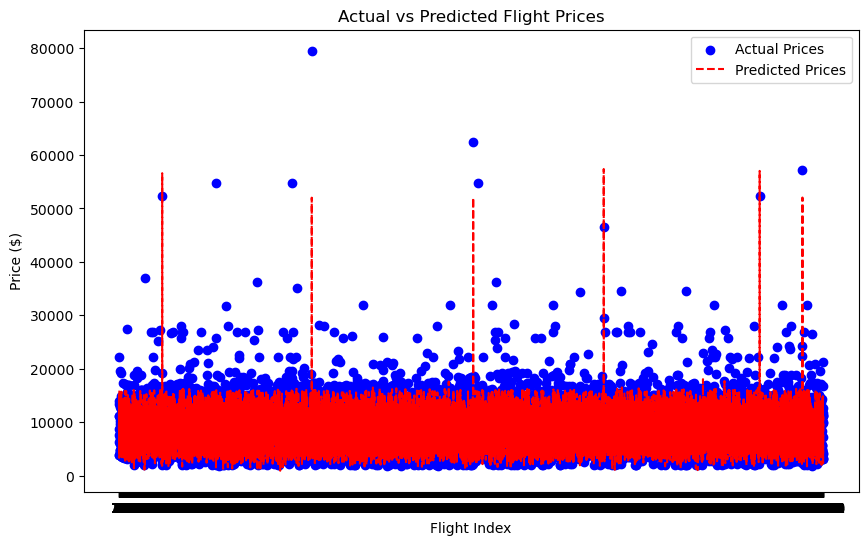

In [33]:
actual_prices = df.Price # Replace with your actual prices
predicted_prices = reg.predict(X)  # Replace with your model's predictions
# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(range(len(actual_prices)), actual_prices, color='blue', label='Actual Prices')
plt.plot(range(len(predicted_prices)), predicted_prices, color='red', linestyle='--', label='Predicted Prices')
plt.title('Actual vs Predicted Flight Prices')
plt.xlabel('Flight Index')
plt.ylabel('Price ($)')
plt.xticks(range(len(actual_prices)))  # Assuming each point is a different flight
plt.legend()
plt.show()


# Decision Tree Prediction

In [26]:
#Decision Tree Prediction
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

# criterion to gini, max_depth to 3  
# defaul values for other parameters.

#modelDT = DecisionTreeClassifier(criterion = 'gini', max_depth = 3)
modelDT = DecisionTreeRegressor(random_state=42)
modelDT.fit(X_train, y_train )
y_pred_rf = modelDT.predict(X_test)
print(y_pred_rf)
y_pred=y_pred_rf
print("Decistion tree model prediction score =",modelDT.score(X_test, y_test))
#print(metrics.roc_auc_score(y_test, y_pred))
#print(metrics.accuracy_score(y_test, y_pred))
#print (X_train.columns.values)

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate RMSE
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

#fig = plt.figure(figsize=(25,20))

#_ = tree.plot_tree(modelDT,feature_names=list(X_train.columns.values),
#                   filled=True)

[12384.  6976. 14388. ...  6015.  3100.  9663.]
Decistion tree model prediction score = 0.8377286749730268
Mean Absolute Error (MAE): 686.9272490899637
Mean Squared Error (MSE): 3277625.6946351193
Root Mean Squared Error (RMSE): 1810.421413548547


# Random Forests

In [402]:
from sklearn.ensemble import RandomForestRegressor


#Future ticket pricing prediction using Random Forest

# Assuming 'X' is your feature set and 'y' is the target variable (ticket prices)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_train, y_train)

# Predict on the test set
y_pred = rf.predict(X_test)

# Evaluate the model
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R-squared:", r2_score(y_test, y_pred))

no_of_features = len(X_train.columns)
depth = int(np.log2(no_of_features))
print("Depth = ",depth)

## Initializing the Random Forest Classifier with max_dept and

## n_estimators

modelRF = RandomForestRegressor(max_depth=depth, n_estimators=100, random_state=101)

# max_depth - log2(no. of features), log()

modelRF.fit(X_train, y_train)
#auc = metrics.roc_auc_score(y_test, modelRF.predict_proba(X_test)[:,1])
print("Score predictions for Randor forest = ",modelRF.score(X_test, y_test))
y_pred = modelRF.predict(X_test[0:10])
print("Ticket price prediction using Random forest = ",y_pred)

Mean Squared Error: 2161173.638596454
R-squared: 0.897884279680347
Depth =  5
Score predictions for Randor forest =  0.7718679036622859
Ticket price prediction using Random forest =  [10819.8735091   8051.45119266 14034.20844303  4469.79381215
 10819.8735091   9555.66362059 14026.07926665  6882.21868397
  4118.27858782 14026.07926665]


 # Actual Vs Predicated prices by comparing Linear regression, Random forest, Decision tree

[ 3897  7662 13882 ...  7229 12648 11753]
[100 150 200 250 300]


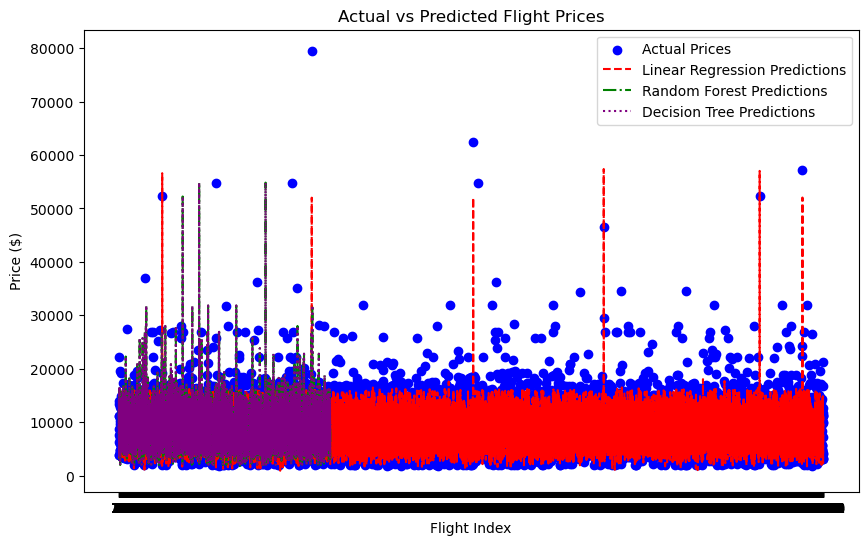

In [28]:

# Sample data: actual prices and predictions from the models
actual_prices2 = np.array([100, 150, 200, 250, 300])  # Replace with your actual prices
actual_prices = np.array(df.Price)  # Replace with your actual prices
predicted_prices_lr = np.array(predicted_prices)  # Linear Regression predictions
predicted_prices_rf = np.array(y_pred)  # Random Forest predictions
predicted_prices_dt = np.array(y_pred_rf)  # Decision Tree predictions

print(actual_prices)
print(actual_prices2)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(range(len(actual_prices)), actual_prices, color='blue', label='Actual Prices')
plt.plot(range(len(predicted_prices_lr)), predicted_prices_lr, color='red', linestyle='--', label='Linear Regression Predictions')
plt.plot(range(len(predicted_prices_rf)), predicted_prices_rf, color='green', linestyle='-.', label='Random Forest Predictions')
plt.plot(range(len(predicted_prices_dt)), predicted_prices_dt, color='purple', linestyle=':', label='Decision Tree Predictions')
plt.title('Actual vs Predicted Flight Prices')
plt.xlabel('Flight Index')
plt.ylabel('Price ($)')
plt.xticks(range(len(actual_prices)))  # Assuming each point is a different flight
plt.legend()
plt.show()


In [5]:
def convert_duration_to_datetime(duration_str):
    #print(duration_str)
    match = re.match(r'(\d+)\s*h\s*(\d*)\s*m', duration_str)
    if match:
        hours = int(match.group(1))
        minutes = int(match.group(2))
        duration = timedelta(hours=hours, minutes=minutes)
        start_time = datetime.min + duration
        return start_time
    else:
        return None  # Return None for invalid format
    
def duration_to_minutes(duration):
    hours, minutes = 0, 0
    if 'h' in duration:
        hours = int(duration.split('h')[0])
        duration = duration.split('h')[1].strip()
    if 'm' in duration:
        minutes = int(duration.split('m')[0])
    return hours * 60 + minutes

def convert_dep_arr_to_datetime(value1,value2):    
    # If the value contains a date (check for the presence of a space and a letter, as in "01:35 04 Mar")
    if ' ' in value1 and any(char.isalpha() for char in value1):        
        year = value2.year
        current_date = pd.to_datetime(str(value1)+ ' '+str(year), format='%H:%M %d %b %Y')        
        #current_date = pd.to_datetime(str(value1)+ ' '+str(year), format='%d/%m/%Y %H:%M')        
        return pd.to_datetime(current_date.strftime('%d/%m/%Y %H:%M'))
    else:
        # Parse value with current date
        #current_date = datetime.now().strftime('%Y-%m-%d')               
        current_date = value2.date().strftime('%d/%m/%Y')
        return pd.to_datetime(str(current_date) + ' ' + value1, format='%d/%m/%Y %H:%M')
    

# Function to categorize part of the day
def part_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

    